# Toy model -- Double peak distribution
This notebook describes the analysis done for this simple model described by:
$$
P(x; \mu, \sigma^2) = \frac{1}{2}\left[\mathcal{N}(\mu,\sigma^2) + \mathcal{N}(-\mu,\sigma^2)\right].
$$

For this work, we set $\mu = 1$ and $\sigma^2 = 1/16$.

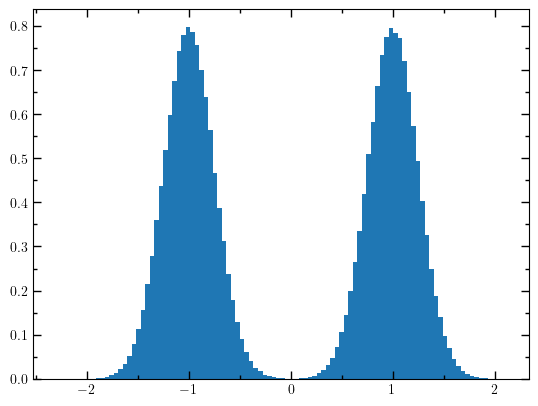

In [135]:
from utils import *
import json

set_default_plot_parameters() #Defines parameters for the plots and figures
device = set_device("cpu") # Set by default to CPU. Supports GPUs like CUDA or MPS (Mac)


mu = 1; sigma = 0.25

samples = np.loadtxt("../data/toy_model/double_peak_samples_1M.dat")
plt.hist(samples,bins=100,density=True)
plt.show()

# Variance Expanding diffusion

## Noise in the forward process

In [3]:
exact_m = np.array([
	sigma**2 + mu**2,
	3 * sigma**4 + 6 * sigma**2 * mu**2 + mu**4, 
	15 * sigma**6 + 45 * sigma**4 * mu**2 + 15*sigma**2 * mu**4 + mu**6,
	105 * sigma**8 + 420 * sigma**6 * mu**2 + 210 * sigma **4 * mu**4 + 28 * sigma**2 * mu**6 + mu**8
	])

exact_c = np.array([sigma**2 + mu**2, -2*mu**4, 16 * mu**6, -272 * mu**8])

max_order = len(exact_c) * 2

In [136]:
# Load data for noise in forward process by size of the dataset
size_labels = ['100K', '1M', '10M']

cumulants_by_size_filenames = ['../data/toy_model/double_peak_cumulants_' + n + '.dat' for n in size_labels]
moments_by_size_filenames = ['../data/toy_model/double_peak_moments_' + n + '.dat' for n in size_labels]

cumulants_by_size = []; moments_by_size = []

for mfile, cfile in zip(moments_by_size_filenames, cumulants_by_size_filenames):
    cumulants_by_size.append(
		np.loadtxt(cfile, delimiter=",").T
	)
    moments_by_size.append(
		np.loadtxt(mfile, delimiter=",").T
	)

# Concatenate and keep only even order cumulants. Odd order cumulants are vanishing.
cumulants_by_size = np.stack(cumulants_by_size, axis=0)[:, 1::2]
moments_by_size = np.stack(moments_by_size, axis=0)[:, 1::2]

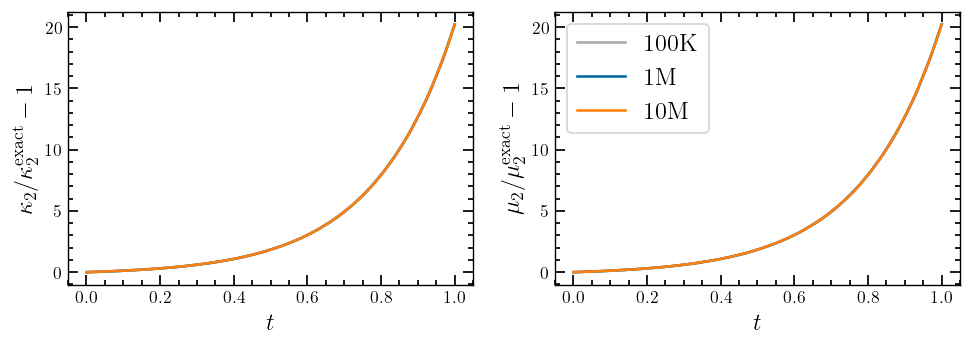

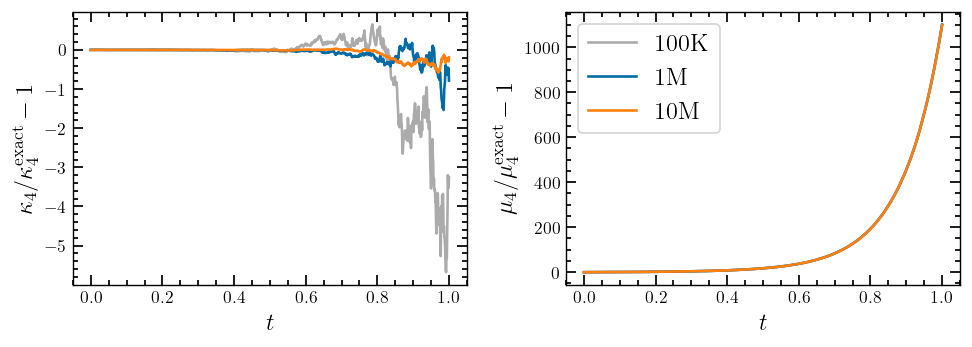

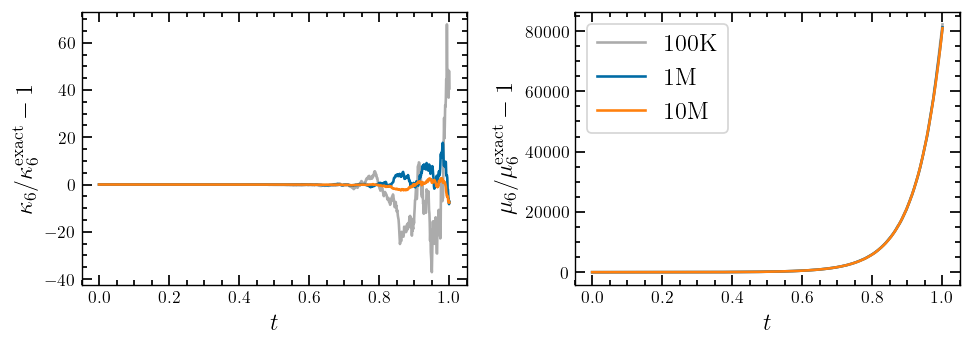

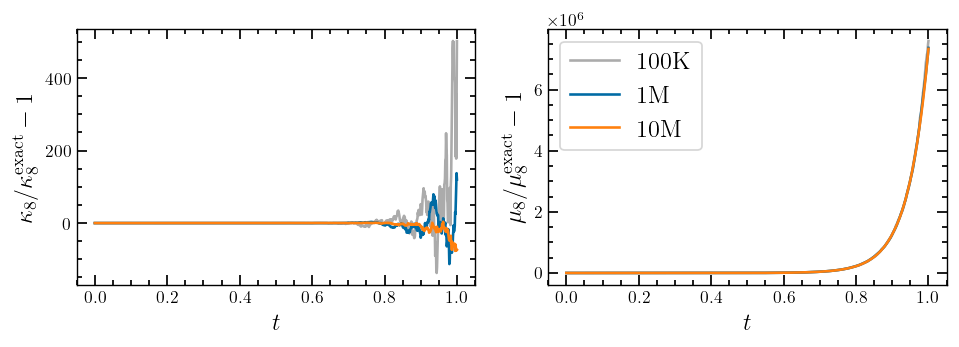

In [137]:
colors = ["#ababab", "#006ba4", "#ff800e"]
stat_c = cumulants_by_size[..., ::10]/exact_c[None, :, None] - 1
stat_m = moments_by_size[..., ::10]/exact_m[None, :, None] - 1
t= np.linspace(0, 1., stat_c.shape[-1])

for j in range(4):
	fig, ax = plt.subplots(1, 2, dpi=125, figsize=(8,3))
	for i, (c, m) in enumerate(zip(stat_c, stat_m)):
		ax[0].plot(t, c[j], label=size_labels[i], color=colors[i])
		ax[0].set_ylabel(f'$\\kappa_{(j+1) * 2}/\\kappa_{(j+1) * 2}^{{\\rm exact}} - 1$')
		ax[0].set_xlabel("$t$")

		ax[1].plot(t, m[j], label=size_labels[i], color=colors[i])
		ax[1].set_ylabel(f'$\\mu_{(j+1) * 2}/\\mu_{(j+1) * 2}^{{\\rm exact}} - 1$')
		ax[1].set_xlabel("$t$")

	plt.legend()
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'figures/cumulant{2 * (j + 1)}_fw_by_size.pdf')

## Backward process - VE

We show here the backward process of the variance expanding scheme using the analytically derived score of the distribution $P(x, t)$,

$$
\partial_x \log P(x, t) = -\frac{x}{\sigma^2(t)} + \frac{\mu_0}{\sigma^2(t)}\tanh\left(\frac{\mu_0}{\sigma^2(t)}\right)
$$
This will let us compare the effects of the trained score model during the evolution of the statistics with the analytically expected behaviour.

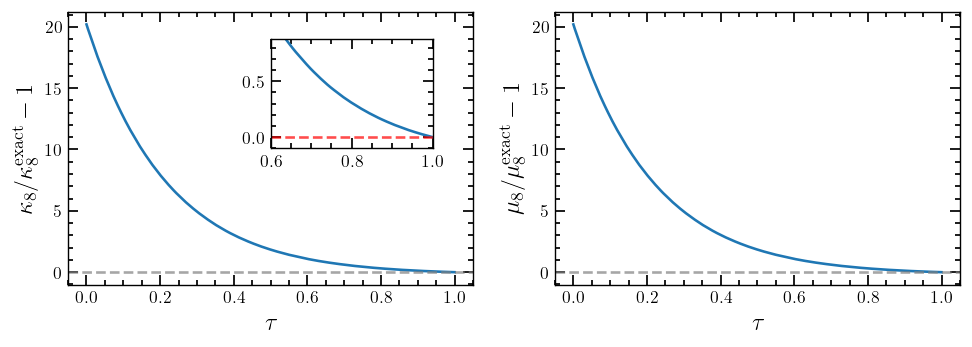

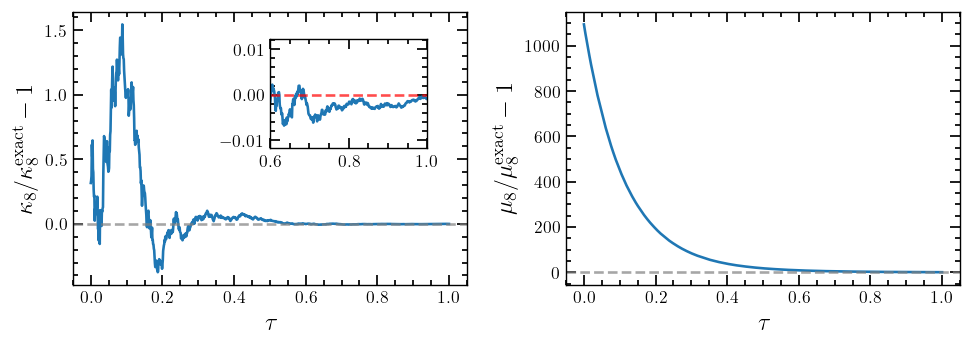

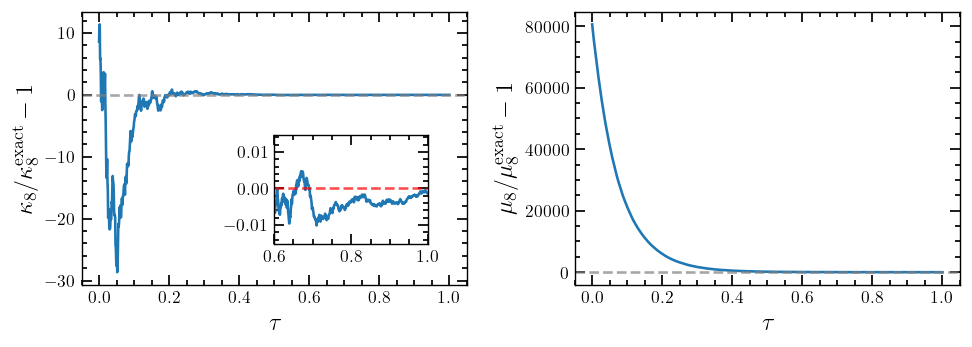

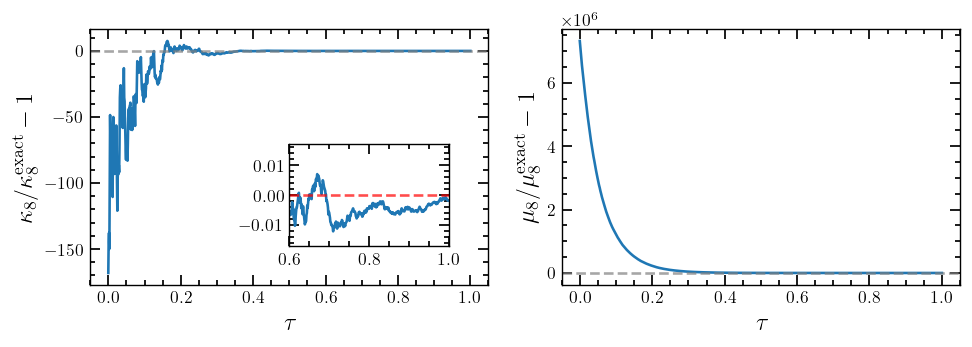

In [138]:
cumulants_bw = np.loadtxt("../data/toy_model/bw_double_peak_cumulants_1M.dat", delimiter=",").T
moments_bw = np.loadtxt("../data/toy_model/bw_double_peak_moments_1M.dat", delimiter=",").T

stat_c = cumulants_bw[1::2]/exact_c[:, None] - 1
stat_m = moments_bw[1::2]/exact_m[:, None] - 1
t = np.linspace(0, 1., stat_c.shape[-1])

subset_mask = (t > 0.6) & (t <= 1.)

y0 = [0.5, 0.5, 0.15, 0.15]
x0 = [0.5, 0.5, 0.5, 0.5]
off_low = [-0.1, -0.005, -.005, -.005]
off_high = [-0.2, 0.01, .01, .01]

for i, (c, m) in enumerate(zip(stat_c, stat_m)):
	fig, ax_ = plt.subplots(1, 2, dpi=125, figsize=(8, 3))
	
	ax_[0].plot(t, c); ax_[1].plot(t, m)
	ax_[0].set_ylabel(f'$\\kappa_{(j+1) * 2}/\\kappa_{(j+1) * 2}^{{\\rm exact}} - 1$')
	ax_[1].set_ylabel(f'$\\mu_{(j+1) * 2}/\\mu_{(j+1) * 2}^{{\\rm exact}} - 1$')
 
	for ax in ax_.ravel():
		ax.axhline(0., ls='--', alpha=0.7, c='gray')
		ax.set_xlabel("$\\tau$")

	
	# Adding the inset
	inset_ax = ax_[0].inset_axes([x0[i], y0[i], 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(t[subset_mask], c[subset_mask])
	inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.6, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + off_low[i], max(c[subset_mask]) + off_high[i])

	plt.tight_layout()

In [7]:
from DiffusionModels import Net, ScoreModel, MarginalProb

model_filename = f"../data/ModelWeights/double_peak_sigma10_weights2.pt"
param_filename = f"../data/ModelWeights/double_peak_sigma10_params2.json"

with open(param_filename) as fp:
	parameters = json.load(fp)

marginal_prob = MarginalProb(sigma=parameters['marginal_prob_sigma'])

net = Net(parameters["input_channels"], parameters["channels"], parameters["time_channels"], activation=torch.nn.LeakyReLU(), device=device)
model = ScoreModel(net, marginal_prob, device=device)
model.load_state_dict(torch.load(model_filename, weights_only=True))

size = int(5e5)
num_steps = 1000

if str(device) == "cpu":
	samples_ve = model.sampler(size, num_steps, history=True, eps=1e-3)		#If using GPUs, prefer to use model.tensor_sampler instead
else:
	samples_ve = grab(model.tensor_sampler(size, num_steps, history=True, eps=1e-3))

samples_ve = np.concat([samples_ve, -samples_ve], axis=1) #Data augmentation using Z_2 symmetry

100%|██████████| 1000/1000 [02:21<00:00,  7.08it/s]


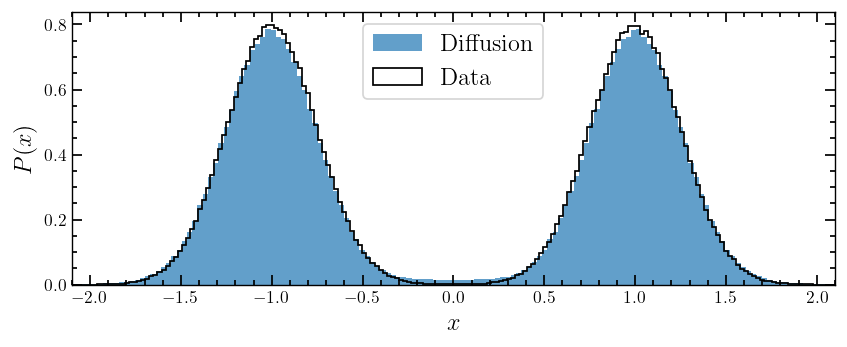

In [8]:
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(7, 3))
ax.hist(samples_ve[-1], density=True, bins=200, label='Diffusion', alpha=0.7)
ax.hist(samples, density=True, bins=200, label='Data', alpha=1, color='black', histtype='step')

ax.set_xlabel('$x$')
ax.set_ylabel('$P(x)$')
ax.set_xlim(-2.1, 2.1)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
cumulants_dm_ve = np.squeeze(nth_cumulants(samples_ve[::5], max_order, axis=1))
moments_dm_ve = np.squeeze([moment(samples_ve[::5], i, axis=1) for i in range(2, max_order+1, 2)])

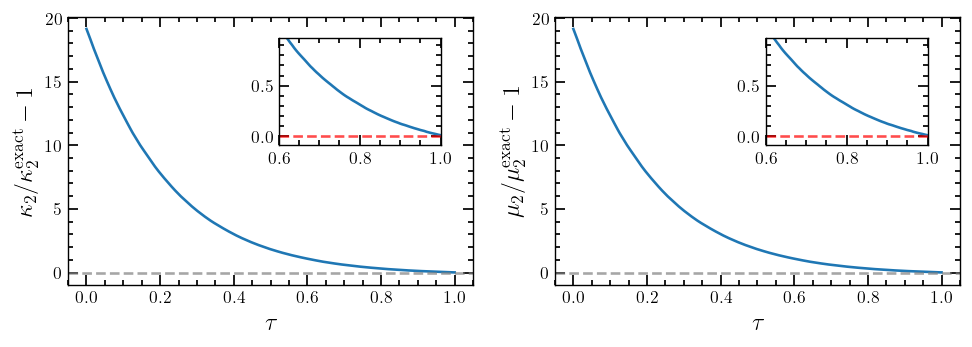

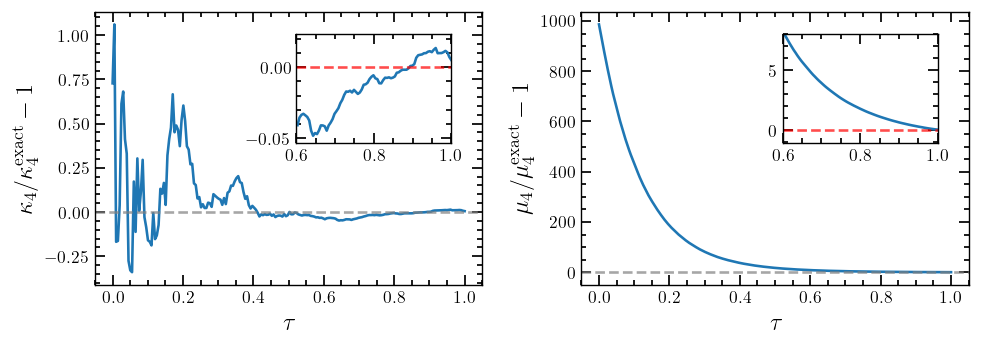

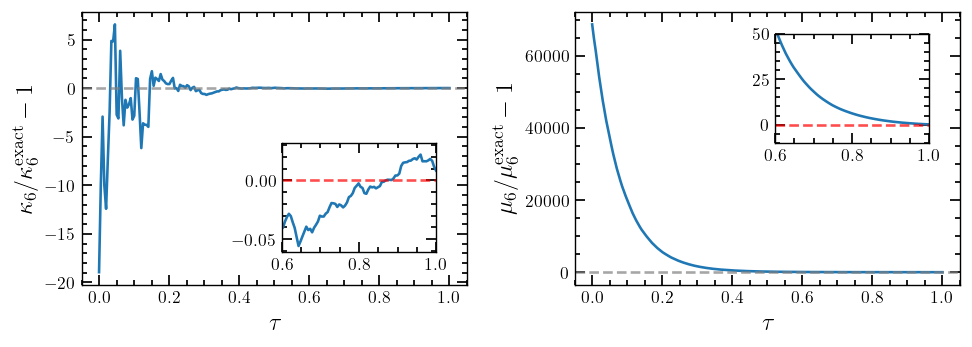

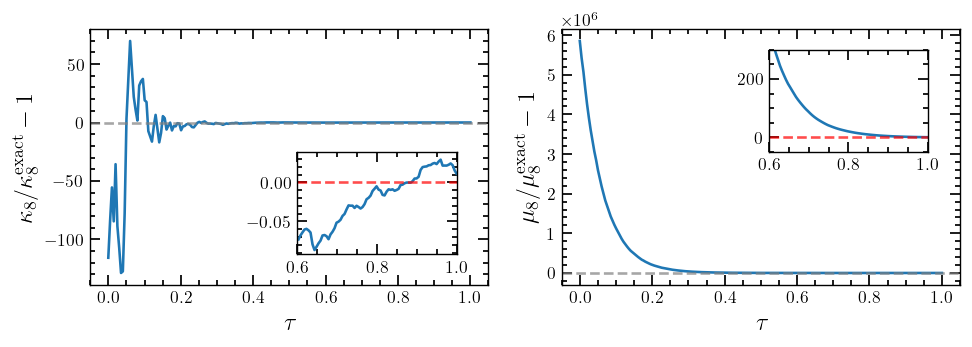

In [155]:
stat_c = cumulants_dm_ve[1::2]/exact_c[:, None] - 1
stat_m = moments_dm_ve/exact_m[:, None] - 1
t = np.linspace(0., 1., stat_c.shape[-1])

subset_mask = (t > 0.6) & (t <= 1.)


for i, (c, m) in enumerate(zip(stat_c, stat_m)):
	fig, ax_ = plt.subplots(1, 2, dpi=125, figsize=(8, 3))

	ax_[0].plot(t, c); ax_[1].plot(t, m)
	ax_[0].set_ylabel(f'$\\kappa_{(i+1) * 2}/\\kappa_{(i+1) * 2}^{{\\rm exact}} - 1$')
	ax_[1].set_ylabel(f'$\\mu_{(i+1) * 2}/\\mu_{(i+1) * 2}^{{\\rm exact}} - 1$')
 
	for ax in ax_.ravel():
		ax.axhline(0., ls='--', alpha=0.7, c='gray')
		ax.set_xlabel("$\\tau$")
	
	# Adding the inset
	y0 = [0.52, 0.52, 0.12, 0.12]
	x0 = [0.52, 0.52, 0.52, 0.52]
	off_low = [-0.1, -0.005, -.005, -.005]
	off_high = [-0.1, 0.01, .01, .01]

	inset_ax = ax_[0].inset_axes([x0[i], y0[i], 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(t[subset_mask], c[subset_mask])
	inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.6, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + off_low[i], max(c[subset_mask]) + off_high[i])

	# Adding the inset
	y0 = [0.52, 0.52, 0.52, 0.52]
	x0 = [0.52, 0.52, 0.52, 0.52]
	off_low = [-0.1, -1, -10, -50]
	off_high = [-0.1, 8., 50, 300]
	
	inset_ax = ax_[1].inset_axes([x0[i], y0[i], 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(t[subset_mask], m[subset_mask])
	inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.6, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + off_low[i], max(c[subset_mask]) + off_high[i])

	plt.tight_layout()

# Variance Preserving diffusion

## Forward Process

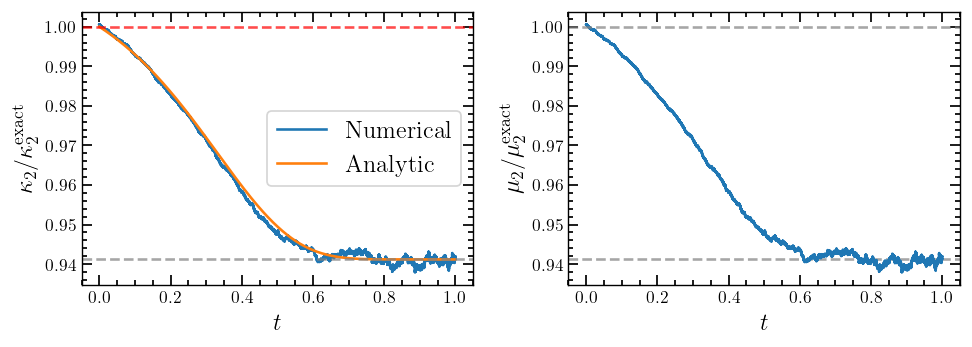

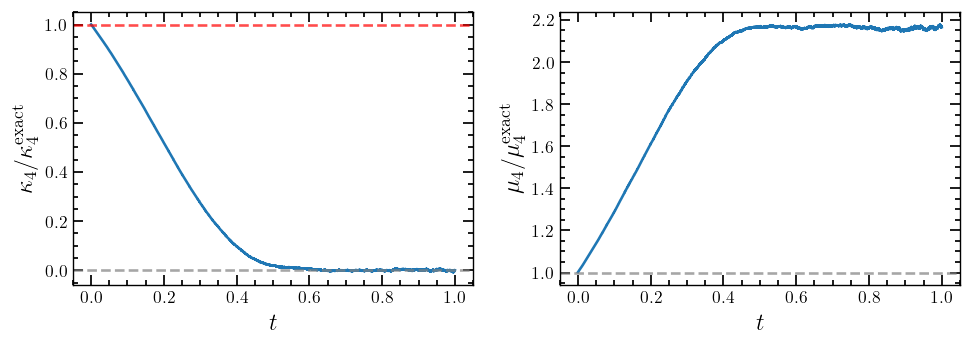

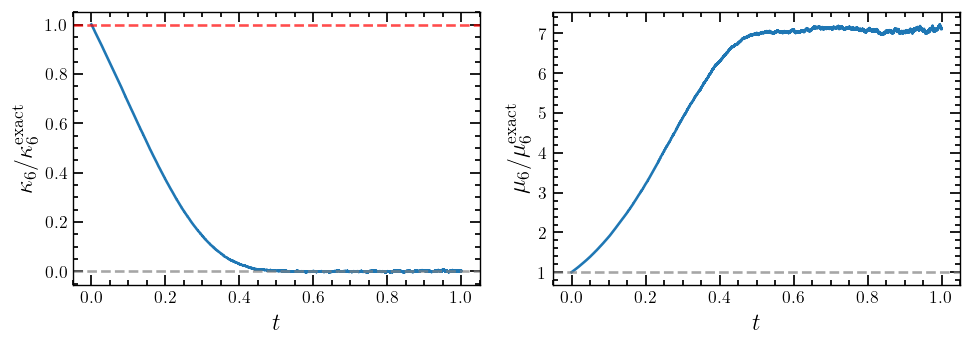

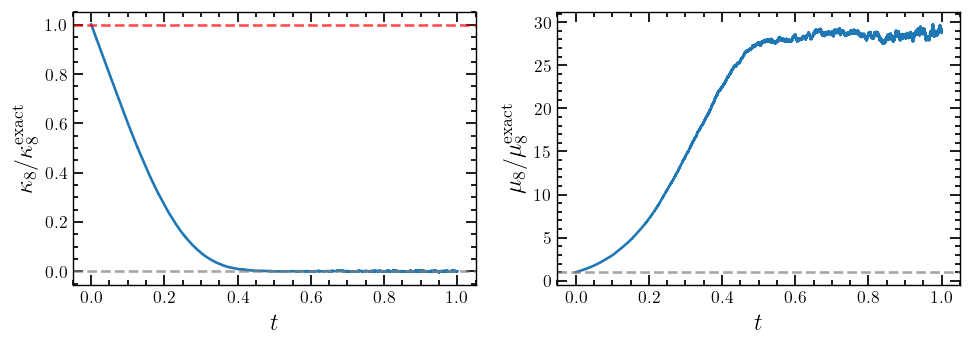

In [142]:
cumulants_fw_vp = np.loadtxt("../data/toy_model/double_peak_cumulants_1M_wdrift.dat", delimiter=",").T
moments_fw_vp = np.loadtxt("../data/toy_model/double_peak_moments_1M_wdrift.dat", delimiter=",").T

stat_c = cumulants_fw_vp[1::2]/exact_c[:, None]
stat_m = moments_fw_vp[1::2]/exact_m[:, None]
t = np.linspace(0, 1., stat_c.shape[-1])

u_t = (10**(2*t) - 1)/2/np.log(10)
foo = ((mu*mu + sigma * sigma - 1) * np.exp(-u_t) + 1) / exact_c[0]

for i, (c, m) in enumerate(zip(stat_c, stat_m)):
	fig, ax_ = plt.subplots(1, 2, dpi=125, figsize=(8, 3))

	ax_[0].plot(t, c, label="Numerical")
	hline = 0.
	if i==0:
		hline = 1./exact_c[0]
		ax_[0].plot(t, foo, label="Analytic")	
		ax_[1].axhline(hline, ls='--', alpha=0.7, c='gray')
	ax_[0].axhline(hline, ls='--', alpha=0.7, c='gray')
	ax_[0].axhline(1., ls='--', alpha=0.7, c='red')

	ax_[0].set_ylabel(f'$\\kappa_{(i+1) * 2}/\\kappa_{(i+1) * 2}^{{\\rm exact}}$')
	ax_[0].set_xlabel("$t$")	
	if i==0:
		ax_[0].legend()

	ax_[1].plot(t, m)
	ax_[1].axhline(1., ls='--', alpha=0.7, c='gray')
	ax_[1].set_ylabel(f'$\\mu_{(i+1) * 2}/\\mu_{(i+1) * 2}^{{\\rm exact}}$')
	ax_[1].set_xlabel("$t$")

	plt.tight_layout()

## Backward Process

### Diffusion model

In [12]:
from DiffusionModels import Net, DriftScoreModel, VPMarginalProb

model_filename = f"../data/ModelWeights/double_peak_sigma10_wdrift_weights.pt"
param_filename = f"../data/ModelWeights/double_peak_sigma10_wdrift_params.json"

with open(param_filename) as fp:
	parameters = json.load(fp)

marginal_prob = VPMarginalProb(sigma=parameters['marginal_prob_sigma'])

net = Net(parameters["input_channels"], parameters["channels"], parameters["time_channels"], activation=torch.nn.LeakyReLU(), device=device)
model_vp = DriftScoreModel(net, marginal_prob, device=device)
model_vp.load_state_dict(torch.load(model_filename, weights_only=True))

size = int(5e5)
num_steps = 1000

if str(device) == "cpu":
	samples_vp = model_vp.sampler(size, num_steps, history=True, eps=1e-3)		#If using GPUs, prefer to use model.tensor_sampler instead
else:
	samples_vp = grab(model_vp.tensor_sampler(size, num_steps, history=True, eps=1e-3))

samples_vp = np.concat([samples_vp, -samples_vp], axis=1)

100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


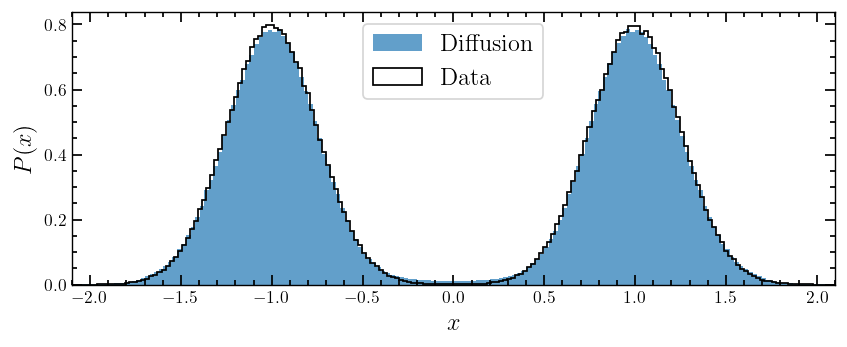

In [13]:
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(7, 3))
ax.hist(samples_vp[-1], density=True, bins=200, label='Diffusion', alpha=0.7)
ax.hist(samples, density=True, bins=200, label='Data', alpha=1, color='black', histtype='step')

ax.set_xlabel('$x$')
ax.set_ylabel('$P(x)$')
ax.set_xlim(-2.1, 2.1)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
cumulants_dm_vp = np.squeeze(nth_cumulants(samples_vp[::5], max_order, axis=1))
moments_dm_vp = np.squeeze([moment(samples_vp[::5], 2 * (i + 1), axis=1) for i in range(max_order//2)])

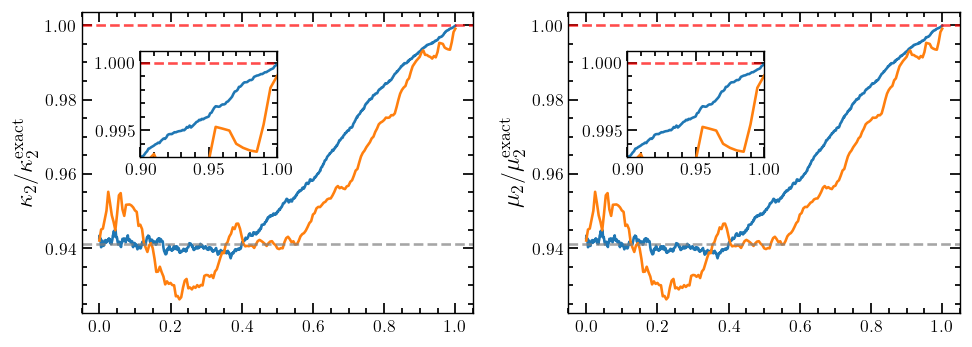

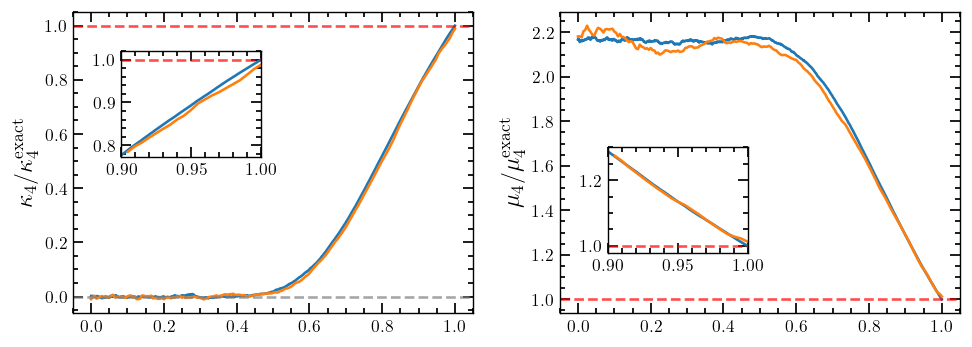

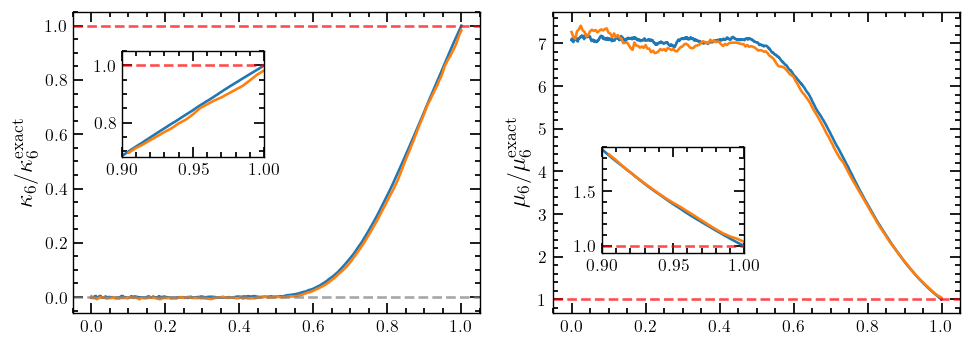

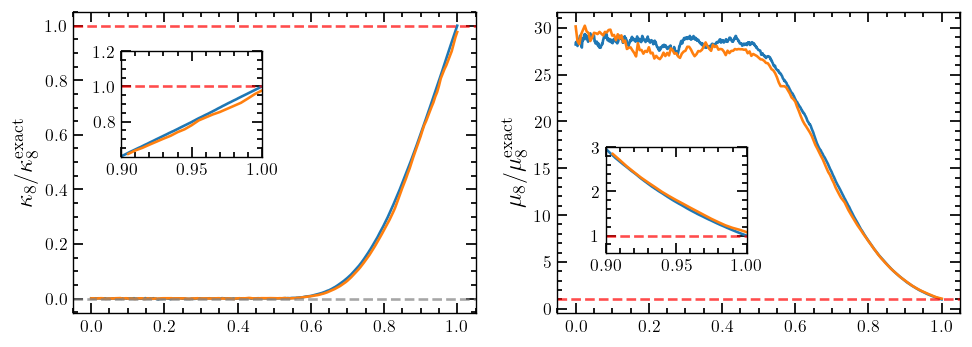

In [77]:
cumulants_bw_vp = np.loadtxt("../data/toy_model/bw_double_peak_cumulants_1M_wdrift.dat", delimiter=",").T
moments_bw_vp = np.loadtxt("../data/toy_model/bw_double_peak_moments_1M_wdrift.dat", delimiter=",").T

stat_c = cumulants_bw_vp[1::2]/exact_c[:, None]
stat_m = moments_bw_vp[1::2]/exact_m[:, None]

stat_c_dm = cumulants_dm_vp[1::2]/exact_c[:, None]
stat_m_dm = moments_dm_vp/exact_m[:, None]


t = np.linspace(0, 1., stat_c.shape[-1])
t_dm = np.linspace(0, 1., stat_c_dm.shape[-1])

subset_mask = (t > 0.9) & (t <= 1.)
subset_mask_dm = (t_dm > 0.9) & (t_dm <= 1.)


for i, (c, m, c_dm, m_dm) in enumerate(zip(stat_c, stat_m, stat_c_dm, stat_m_dm)):
	fig, ax_ = plt.subplots(1, 2, dpi=125, figsize=(8, 3))
	
	ax_[0].plot(t, c); ax_[0].plot(t_dm, c_dm)
	ax_[1].plot(t, m); ax_[1].plot(t_dm, m_dm)
	ax_[0].set_ylabel(f'$\\kappa_{(i+1) * 2}/\\kappa_{(i+1) * 2}^{{\\rm exact}}$')
	ax_[1].set_ylabel(f'$\\mu_{(i+1) * 2}/\\mu_{(i+1) * 2}^{{\\rm exact}}$')

	hline = 0.
	if i==0:
		hline = 1./exact_c[0]
		ax_[1].axhline(hline, ls='--', alpha=0.7, c='gray')
	ax_[1].axhline(1., ls='--', alpha=0.7, c='red')
	ax_[0].axhline(hline, ls='--', alpha=0.7, c='gray')
	ax_[0].axhline(1., ls='--', alpha=0.7, c='red')
	
	# Adding the inset
	y0 = [0.52, 0.52, 0.52, 0.52]
	x0 = [0.15, 0.12, 0.12, 0.12]
	off_low = [0, -0.005, -.005, -.005]
	off_high = [0.001, 0.02, .05, .2]

	inset_ax = ax_[0].inset_axes([x0[i], y0[i], 0.35, 0.35])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(t[subset_mask], c[subset_mask])
	inset_ax.plot(t_dm[subset_mask_dm], c_dm[subset_mask_dm])
	inset_ax.axhline(1., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.9, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + off_low[i], max(c[subset_mask]) + off_high[i])

	# Adding the inset
	y0 = [0.52, 0.2, 0.2, 0.2]
	x0 = [0.15, 0.12, 0.12, 0.12]
	off_low = [0, 0.2, 0.25, 0]
	off_high = [0.001, 0.3, .9, 2]

	inset_ax = ax_[1].inset_axes([x0[i], y0[i], 0.35, 0.35])  # [x0, y0, width, height] in relative coordinates
	inset_ax.plot(t[subset_mask], m[subset_mask])
	inset_ax.plot(t_dm[subset_mask_dm], m_dm[subset_mask_dm])
	inset_ax.axhline(1., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.9, 1.0)
	inset_ax.set_ylim(min(c[subset_mask]) + off_low[i], max(c[subset_mask]) + off_high[i])

	plt.tight_layout()

## $\phi^4$ Field Theory


In [98]:
# Load data
O_fw = []; O_bw = []
for i in range(3):
	O_fw.append(np.load(f'../data/field_theory/O{2*(i+1)}_forward.npy'))
	O_bw.append(np.load(f'../data/field_theory/O{2*(i+1)}.npy'))
O_fw = np.stack(O_fw)
O_bw = np.stack(O_bw)

In [103]:
O_bw.shape

(3, 200)

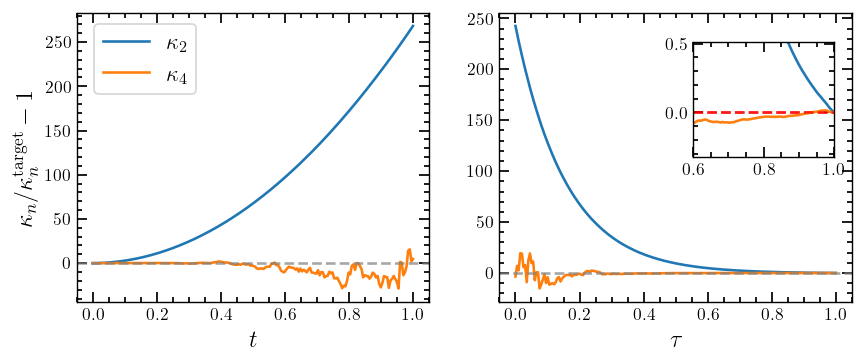

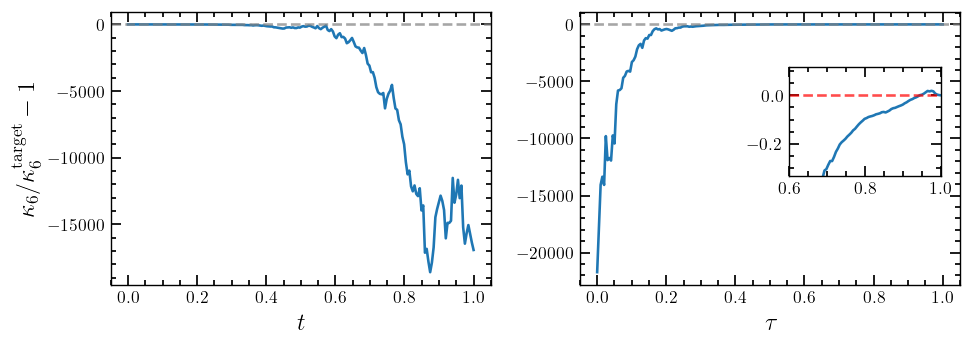

In [134]:
stat_fw = O_fw / O_fw[:, 0, None] - 1
stat_bw = O_bw / O_bw[:, -1, None] - 1

t = np.linspace(0., 1., stat_bw.shape[-1])

subset_mask = (t > 0.6) & (t <= 1.)

fig, ax_ = plt.subplots(1, 2, dpi=125, figsize=(8, 3))
inset_ax = ax_[1].inset_axes([0.55, 0.5, 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates

for i in range(2):
	ax_[0].plot(t, stat_fw[i], label=f"$\\kappa_{2 * (i+1)}$")
	ax_[1].plot(t, stat_bw[i])

	# Adding the inset
	inset_ax.plot(t[subset_mask], stat_bw[i, subset_mask])
	inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
	inset_ax.set_xlim(0.6, 1.0)
	inset_ax.set_ylim(min(stat_bw[i, subset_mask]) - 0.25, max(stat_bw[i, subset_mask]) + 0.5)

ax_[0].set_ylabel(f'$\\kappa_n/\\kappa_n^{{\\rm target}} - 1$')
ax_[0].set_xlabel("$t$"); ax_[1].set_xlabel("$\\tau$")
ax_[0].legend(fontsize=13, loc=(0.05, 0.72))

for ax in ax_.ravel():
	ax.axhline(0., ls='--', alpha=0.7, c='gray')


fig, ax_ = plt.subplots(1, 2, dpi=125, figsize=(8, 3))
inset_ax = ax_[1].inset_axes([0.55, 0.4, 0.4, 0.4])  # [x0, y0, width, height] in relative coordinates

ax_[0].plot(t, stat_fw[-1]); ax_[1].plot(t, stat_bw[-1])

inset_ax.plot(t[subset_mask], stat_bw[-1, subset_mask])
inset_ax.axhline(0., ls='--', alpha=0.7, c='red')
inset_ax.set_xlim(0.6, 1.0)
inset_ax.set_ylim(min(stat_bw[-1, subset_mask]) + .5, max(stat_bw[-1, subset_mask]) + 0.1)

ax_[0].set_ylabel(f'$\\kappa_6/\\kappa_6^{{\\rm target}} - 1$')
ax_[0].set_xlabel("$t$"); ax_[1].set_xlabel("$\\tau$")

for ax in ax_.ravel():
	ax.axhline(0., ls='--', alpha=0.7, c='gray')

plt.tight_layout()
plt.show()